In [33]:
import pandas as pd

ua = pd.read_csv('ua_1y.csv')
ua.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2019-10-14,18.219999,18.430000,18.139999,18.230000,1309500,0,0
1,2019-10-15,18.240000,18.500000,18.110001,18.459999,1267700,0,0
2,2019-10-16,18.500000,18.549999,18.299999,18.360001,1400700,0,0
3,2019-10-17,18.480000,18.645000,18.360001,18.459999,1382500,0,0
4,2019-10-18,18.000000,18.049999,17.594999,17.809999,2472300,0,0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

xs = pd.to_datetime(ua['Date'])
ys = ua['Close']

def base_plot():
    plt.plot(xs, ys)
    plt.title('UNDER ARMOUR STOCK PRICES (OCT-2019 - OCT-2020)')
    plt.ylabel('PRICE (US Dollars)')
    plt.yticks(np.arange(np.floor(ys.min()) - 2, np.ceil(ys.max()) + 4, step=2))

    xaxis = plt.gca().xaxis
    xaxis.set_major_locator(mdates.MonthLocator())
    xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    plt.margins(x=0)

## Prices

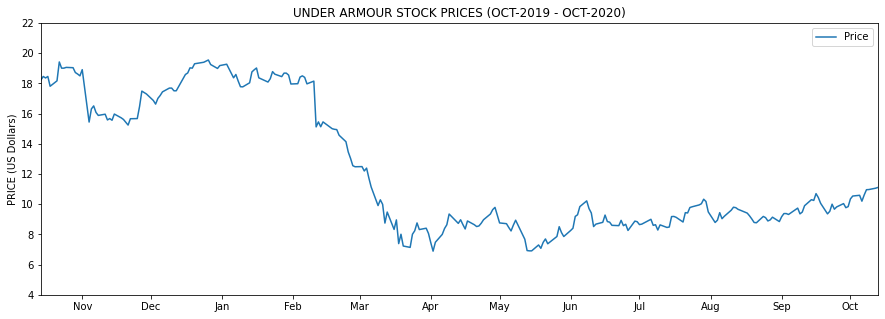

In [3]:
plt.figure(figsize=(15, 5))
base_plot()

plt.legend(['Price'])
plt.show()

## Trend: EMA 50/200

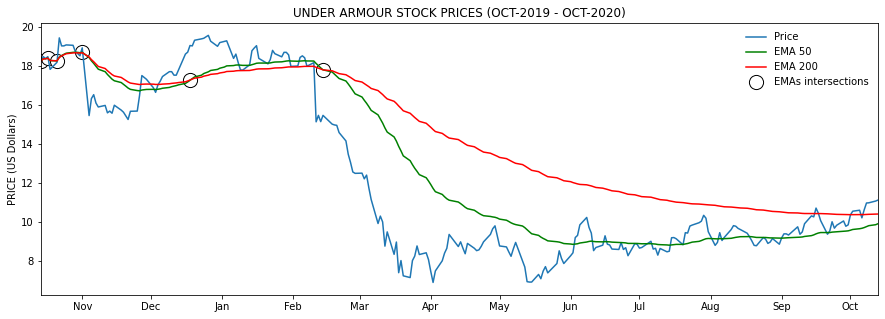

In [20]:
ua['EMA 50']  = ua['Close'].ewm(span=50).mean()
ua['EMA 200'] = ua['Close'].ewm(span=200).mean()

plt.figure(figsize=(15, 5))

base_plot()
plt.plot(xs, ua['EMA 50'], color='green')
plt.plot(xs, ua['EMA 200'], color='red')

# INSERSECTIONS
# https://stackoverflow.com/questions/28766692/intersection-of-two-graphs-in-python-find-the-x-value
idx = np.argwhere(np.diff(np.sign(ua['EMA 50'] - ua['EMA 200']))).flatten()
plt.scatter(xs[idx], ua['EMA 50'].iloc[idx], s=200, color='w', edgecolor='black', linewidths=1)

plt.legend(['Price', 'EMA 50', 'EMA 200', 'EMAs intersections'], frameon=False)

plt.show()

## Mean: Bollinger bands

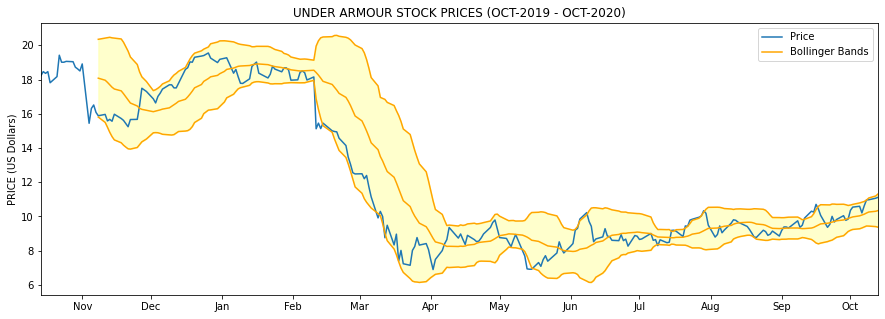

In [30]:
# TYPICAL PRICE
ua['Typical Price'] = (ua['Open'] + ua['Close'] + ua['High']) / 3

# MOVING AVERAGE AND STANDARD DEVIATION (20 DAYS)
ua['MA 20']    = ua['Typical Price'].rolling(window=20).mean()
ua['STD 20']   = ua['Typical Price'].rolling(window=20).std()

# UPPER/LOWER BANDS
ua['UpperBol'] = ua['MA 20'] + (2 * ua['STD 20'])
ua['LowerBol'] = ua['MA 20'] - (2 * ua['STD 20'])

# DRAWING MA, UPPER AND LOWER BANDS
plt.figure(figsize=(15, 5))

base_plot()
plt.plot(xs, ua['MA 20'], color='orange')
plt.plot(xs, ua['UpperBol'], color='orange')
plt.plot(xs, ua['LowerBol'], color='orange')
plt.legend(['Price', 'Bollinger Bands'])

plt.fill_between(xs, ua['UpperBol'], ua['LowerBol'], color='yellow', alpha=0.2)
plt.show()

## Relative strength: Stochastics

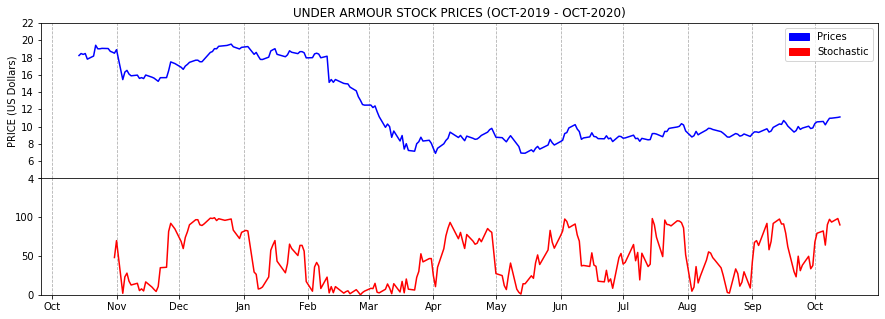

In [6]:
# LOWEST AND HIGHEST 14 PREVIOUS DAYS
ua['L14'] = ua['Low'].rolling(14).min()
ua['H14'] = ua['High'].rolling(14).max()

ua['SO'] = ((ua['Close'] - ua['L14']) / (ua['H14'] - ua['L14'])) * 100

# DRAWING SO
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

# GRID TO LOCATE PRICE AND SO CHARTS
fig = plt.figure(figsize=(15, 5))
gsp = GridSpec(2, 1, height_ratios=[4, 3], hspace=0)

ax1 = fig.add_subplot(gsp[0])
ax2 = fig.add_subplot(gsp[1], sharex=ax1)

# PRICE CHART
ax1.plot(xs, ys, label='Price', color="blue")
ax1.set_title('UNDER ARMOUR STOCK PRICES (OCT-2019 - OCT-2020)')
ax1.set_ylabel('PRICE (US Dollars)')
ax1.set_yticks(np.arange(np.floor(ys.min()) - 2, np.ceil(ys.max()) + 4, step=2))
ax1.set_xticks([])
ax1.grid(axis='x', linestyle='--')

# SO CHART
xaxis = ax2.xaxis
xaxis.set_major_locator(mdates.MonthLocator())
xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax2.plot(xs, ua['SO'], color='red', linestyle='-')
ax2.grid(axis='x', linestyle='--')

# HIDDING LAST Y TICKS IN SO CHART
ax2.set_yticks(np.arange(0, 200, step=50))
ax2.set_ylim(0, 150)
plt.setp(ax2.get_yticklabels()[-1], visible=False)

# COMBINED LEGEND
prices_patch = mpatches.Patch(color='blue', label='Prices')
stocha_patch = mpatches.Patch(color='red', label='Stochastic')
ax1.legend(handles=[prices_patch, stocha_patch])
plt.show()

## Momentum: MACD

In [7]:
# EMA-26 & EMA-12
ua['EMA 26']      = ua['Close'].ewm(span=26).mean()
ua['EMA 12']      = ua['Close'].ewm(span=12).mean()

# MACD = EMA-12 - EMA-26
ua['MACD']        = ua['EMA 12'] - ua['EMA 26']

# MACD-SIGNAL = EMA-9(MACD)
# https://school.stockcharts.com/doku.php?id=technical_indicators:moving_average_convergence_divergence_macd
ua['MACD SIGNAL'] = ua['MACD'].ewm(span=9).mean()

# MACD HISTOGRAM = MACD - MACD-SIGNAL
ua['MACD HIST'] = ua['MACD'] - ua['MACD SIGNAL']

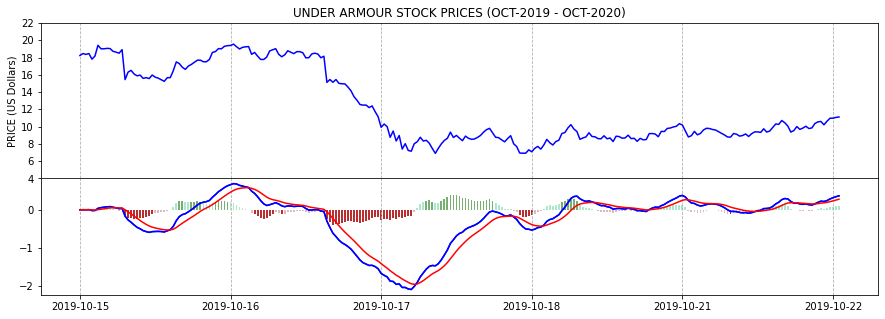

In [8]:
import matplotlib.ticker as ticker

from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

# GRID TO LOCATE PRICE AND SO CHARTS
sto = plt.figure(figsize=(15, 5))
gsp = GridSpec(2, 1, height_ratios=[4, 3], hspace=0)

st1 = sto.add_subplot(gsp[0])
st2 = sto.add_subplot(gsp[1], sharex=st1)

# USING A NORMALIZED X AXIS TICKS
thex = np.arange(len(ua))

# DRAWING PRICE CHART
st1.plot(thex, ys, label='Price', color="blue")
st1.set_title('UNDER ARMOUR STOCK PRICES (OCT-2019 - OCT-2020)')
st1.set_ylabel('PRICE (US Dollars)')
st1.set_yticks(np.arange(np.floor(ys.min()) - 2, np.ceil(ys.max()) + 4, step=2))
st1.grid(axis='x', linestyle='--')

# DRAWING MACD CHART
st2.plot(thex, ua['MACD'], color='blue')
st2.plot(thex, ua['MACD'], color='blue')
st2.plot(thex, ua['MACD SIGNAL'], color='red')

pos_his1 = ua.loc[ua['MACD HIST'] > 0.2]
pos_his2 = ua.loc[(ua['MACD HIST'] >= 0.0) & (ua['MACD HIST'] <= 0.2)]

neg_his1 = ua.loc[(ua['MACD HIST'] < 0) & (ua['MACD HIST'] >= -0.1)]
neg_his2 = ua.loc[ua['MACD HIST'] < -0.1]

st2.bar(pos_his1.index, pos_his1['MACD HIST'], width=0.6, color='#77af70')
st2.bar(pos_his2.index, pos_his2['MACD HIST'], width=0.6, color='#ace6cb')
st2.bar(neg_his1.index.values, neg_his1['MACD HIST'], width=0.6, color='#dababa')
st2.bar(neg_his2.index.values, neg_his2['MACD HIST'], width=0.6, color='#b92f2f')

st2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: ua.iloc[pos, 0]))

st2.grid(axis='x', linestyle='--')
plt.show()

## On-Balance Volume (OBV)

In [9]:
ua['OBV'] = np.where(
    ua['Close'] > ua['Close'].shift(1), ua['Volume'], 
    np.where(ua['Close'] < ua['Close'].shift(1), -ua['Volume'], 0)
).cumsum()

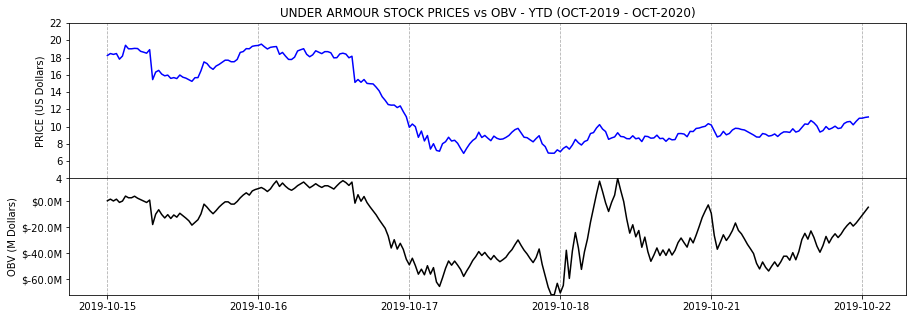

In [31]:
import matplotlib.ticker as ticker

from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter

# GRID TO LOCATE BOTH CHARTS
sto = plt.figure(figsize=(15, 5))
gsp = GridSpec(2, 1, height_ratios=[4, 3], hspace=0)

st1 = sto.add_subplot(gsp[0])
st2 = sto.add_subplot(gsp[1], sharex=st1)

# SHARED X VALUES
thex = np.arange(len(ua))

# PRICE CHART
st1.plot(thex, ys, label='Price', color="blue")
st1.set_title('UNDER ARMOUR STOCK PRICES vs OBV - YTD (OCT-2019 - OCT-2020)')
st1.set_ylabel('PRICE (US Dollars)')
st1.set_yticks(np.arange(np.floor(ys.min()) - 2, np.ceil(ys.max()) + 4, step=2))
st1.grid(axis='x', linestyle='--')

# OBV CHART
st2.plot(thex, ua['OBV'], color='black')

# FUNCTION TO FORMAT MILLIONS
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)
st2.yaxis.set_major_formatter(formatter)
st2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: ua.iloc[pos, 0]))
st2.grid(axis='x', linestyle='--')
st2.set_ylabel('OBV (M Dollars)')
st2.set_ylim([ua['OBV'].min() - 1000, ua['OBV'].max() + 1000])
plt.show()

## mplfinance library

In [35]:
import sys
!{sys.executable} -m pip install mplfinance

     |████████████████████████████████| 55 kB 332 kB/s eta 0:00:011


<Mpf_Figure size 640x480 with 0 Axes>

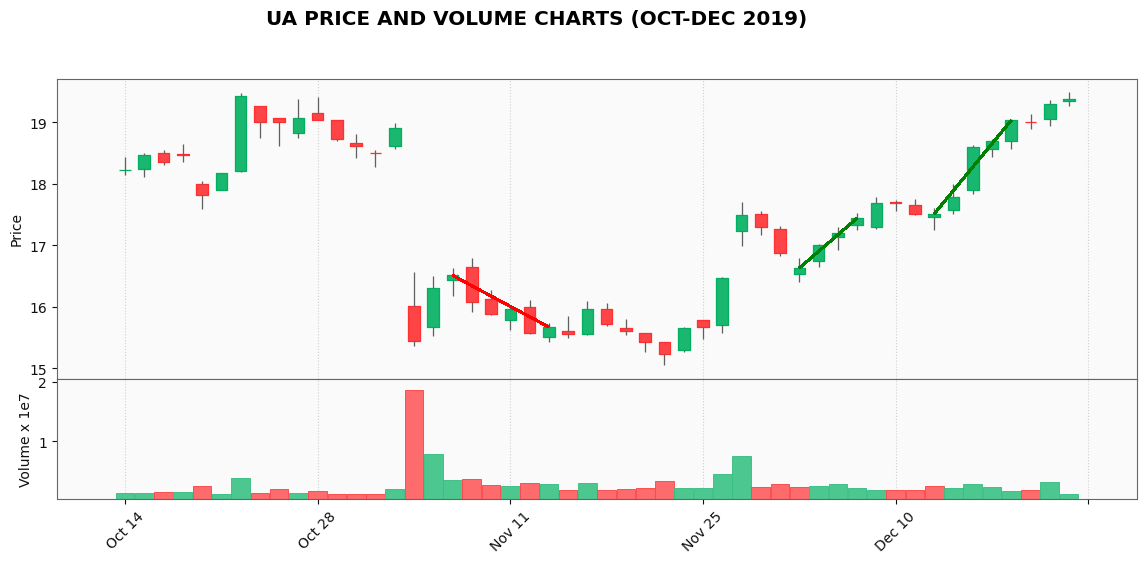

In [124]:
import mplfinance as mpl

# it requires the index to be a time series
ua['Date'] = pd.to_datetime(ua['Date'])

mpl.figure()

# adjusting overall styles
style = mpl.make_mpf_style(
    y_on_right=False,
    base_mpf_style='yahoo',
    gridaxis='vertical',
    edgecolor='#666666',
    gridstyle=':')


data = ua.set_index('Date').iloc[0:50]
# almost everything happens within the plot() function
mpl.plot(
    data, # first 30 days
    type='candle', 
    volume=True, 
    title='UA PRICE AND VOLUME CHARTS (OCT-DEC 2019)',
    style=style,
    figratio=(11,8),
    figscale=0.85,
    figsize=(15, 6),
    mav=(),
    tlines=[
        dict(tlines=[('2019-11-06', '2019-11-13')], colors='r'),
        dict(tlines=[('2019-12-03', '2019-12-08'), ('2019-12-12', '2019-12-18')], colors='g')
    ])

mpl.show()